This file is basically the same as random_perturbations_logdi except generalized to multiple p's. 

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import model_bias_analysis
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # comment this out if higher resolution is not needed

In [2]:
# Remember to always check that these files look the way you want before you run this! See data-di-with-gay to regenerate.

joined_tox = pd.read_csv('joined_tox.csv')
train_comments = pd.read_csv('train_comments.csv')
test_comments = pd.read_csv('test_comments.csv')
madlibs_terms = ['gay', 'homosexual', 'straight', 'black', 'white', 'american', 'jewish', 'old']

In [13]:
# Generates perturbations.
# Basically, creates num_perturbations number of arrays.
# Each array is the length of train_comments.
# Each element in each array is 0 or 1.
# For each element, with probability p, we replace it.
# What do we replace it with? A zero or one, chosen at random. (np.random.randint(2)).

def generate_perturbation_on_training(train_comments, num_perturbations, p): # perturbations
    print("Probability p, with which we replace a label: ", p)
    
    list_perturbation = [] # perturbations
    rand = []
    tox_tmp = []
    num_replaced = 0 # number of synthetic labels
    
    length = len(train_comments.binary_tox.values)
    for j in range(num_perturbations):
        rand = np.random.random(length) # generate a random number (between 0 and 1) for each comment
        tox_tmp = np.copy(train_comments.binary_tox.values) # np.copy(tox_np)
        for i in range(length):
            if rand[i] <= p: 
                tox_tmp[i] = np.random.randint(2)
                num_replaced += 1
        list_perturbation.append(tox_tmp)

    # each item in list_perturbation is a list of 0s and 1s that correspond to the new binary_tox of each variable
    print(num_replaced)
    return list_perturbation

In [14]:
def train_and_predict(train_comments, list_perturbations_training, test_comments, num_perturbations):

    # This trains a logistic regression classifier on each perturbed dataset.
    d={}
    for x in range(NUM_PERTURBATIONS):
        d["clf{0}".format(x)] = Pipeline([
            ('vect', CountVectorizer(max_features = 10000, ngram_range = (1,2))),
            ('tfidf', TfidfTransformer(norm = 'l2')),
            ('clf', LogisticRegression()),
        ])
        d["clf{0}".format(x)] = d["clf{0}".format(x)].\
                                    fit(train_comments['comment'], list_perturbations_training[x])
        d["auc{0}".format(x)] = roc_auc_score(test_comments['binary_tox'], \
                                    d["clf{0}".format(x)].predict_proba(test_comments['comment'])[:, 1])
        print('x Test ROC AUC: %.5f' %d["auc{0}".format(x)])
        
    # After training classifiers, we use them to predict labels for our test datasets!
    perturbed_predictions = [] # Each element is an array of predicted labels.
    # The 0th element is an array of predicted labels for the 0th perturbed dataset.

    for i in range(NUM_PERTURBATIONS):
        perturbed_predictions.append(d["clf{0}".format(i)].predict(test_comments['comment']))
                                                                                 
    return perturbed_predictions

In [5]:
def logDI(df, labels_col, terms):
    # labels_col is true/false of the comment being classified as toxic. ('binary_tox' I believe)
    # terms should be the array of top 8 terms
    
    logDI_arr = np.empty(((len(terms)), len(terms)))
    
    for i in range(len(terms)):
        for j in range(len(terms)):
            # print("******", i)
            logDI_arr[i, j] =  (math.log(len(df[(df[terms[i]]==True) & (df[labels_col]==True)]) / len(df[df[terms[i]]==True])) \
                            - math.log(len(df[(df[terms[j]]==True) & (df[labels_col]==True)]) / len(df[df[terms[j]]==True])))**2
                
    logDI = logDI_arr.sum() / 2
    return logDI

In [6]:
def find_avg_logDI(list_perturbations, df, madlibs_terms):
    # find logDI for each item in list_perturbations_training
    logs = []
    for i in range(len(list_perturbations)):
        namecol = 'perturbation' + str(i)
        df[namecol] = list_perturbations[i]
        logs.append(logDI(df, namecol, madlibs_terms))
    return np.mean(logs)

In [31]:
p_vals = [0.20, 0.40, 0.50, 0.60, 0.80]
logs_training = []
logs_test = []
list_training = []
list_test = []
NUM_PERTURBATIONS = 10 # This is the number of perturbations we're doing on EACH p-val below
for i in range(len(p_vals)):
    probability_flip = p_vals[i]
    list_perturbations_training = generate_perturbation_on_training(train_comments, NUM_PERTURBATIONS, probability_flip)
    list_training.append(list_perturbations_training)
    logs_training.append(find_avg_logDI(list_perturbations_training, train_comments, madlibs_terms))
    perturbed_predictions = train_and_predict(train_comments, list_perturbations_training, test_comments, NUM_PERTURBATIONS)
    list_test.append(perturbed_predictions)
    logs_test.append(find_avg_logDI(perturbed_predictions, test_comments, madlibs_terms))

probflip 0.2
765475
x Test ROC AUC: 0.75073
x Test ROC AUC: 0.75125
x Test ROC AUC: 0.75503
x Test ROC AUC: 0.75332
x Test ROC AUC: 0.75494
x Test ROC AUC: 0.75259
x Test ROC AUC: 0.75811
x Test ROC AUC: 0.75465
x Test ROC AUC: 0.75331
x Test ROC AUC: 0.75611
probflip 0.4
574842
x Test ROC AUC: 0.86569
x Test ROC AUC: 0.86267
x Test ROC AUC: 0.85837
x Test ROC AUC: 0.86693
x Test ROC AUC: 0.86750
x Test ROC AUC: 0.86039
x Test ROC AUC: 0.86712
x Test ROC AUC: 0.86305
x Test ROC AUC: 0.85802
x Test ROC AUC: 0.86398
probflip 0.5
478572
x Test ROC AUC: 0.88981
x Test ROC AUC: 0.89095
x Test ROC AUC: 0.89249
x Test ROC AUC: 0.89696
x Test ROC AUC: 0.89614
x Test ROC AUC: 0.88876
x Test ROC AUC: 0.88672
x Test ROC AUC: 0.89397
x Test ROC AUC: 0.89246
x Test ROC AUC: 0.89097
probflip 0.6
382520
x Test ROC AUC: 0.91546
x Test ROC AUC: 0.91567
x Test ROC AUC: 0.91212
x Test ROC AUC: 0.91707
x Test ROC AUC: 0.91348
x Test ROC AUC: 0.91048
x Test ROC AUC: 0.91408
x Test ROC AUC: 0.91081
x Test R

Text(0,0.5,'Test Data log DI of two terms')

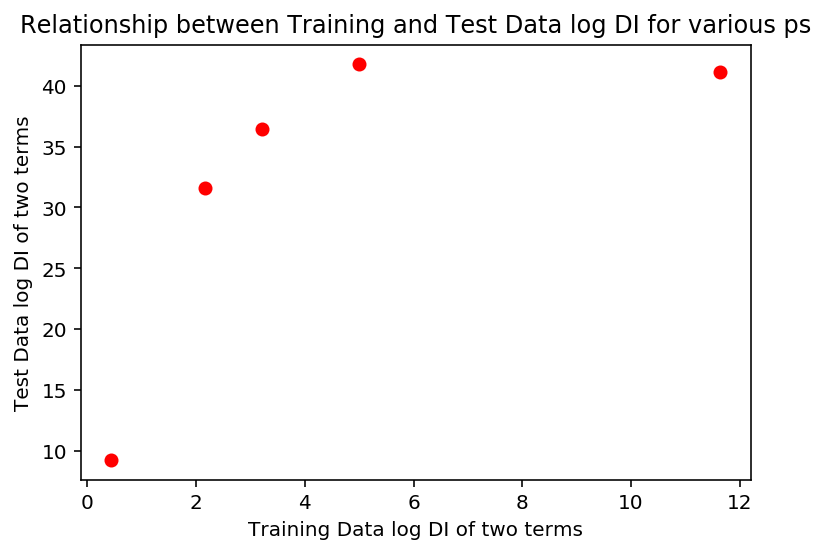

In [32]:
plt.plot(logs_training, logs_test, "ro")
plt.title("Relationship between Training and Test Data log DI for various ps")
plt.xlabel("Training Data log DI of two terms")
plt.ylabel("Test Data log DI of two terms")

Text(0,0.5,'log DI of training')

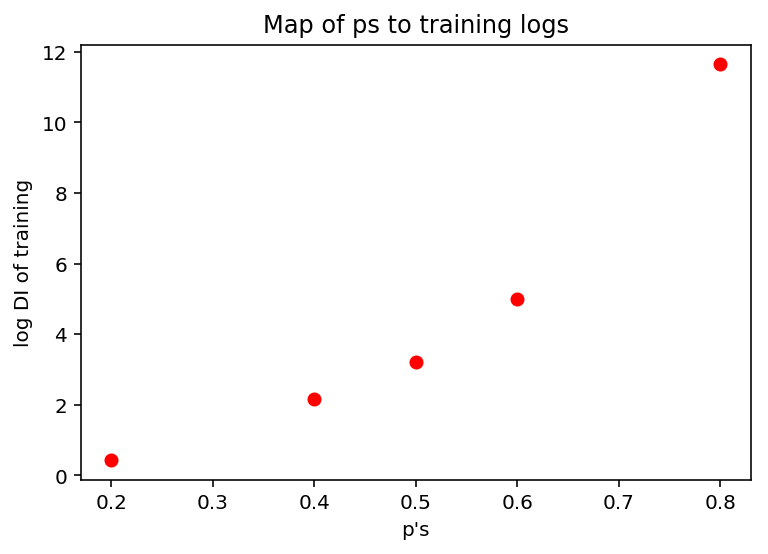

In [33]:
plt.plot(p_vals, logs_training, "ro")
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of training')

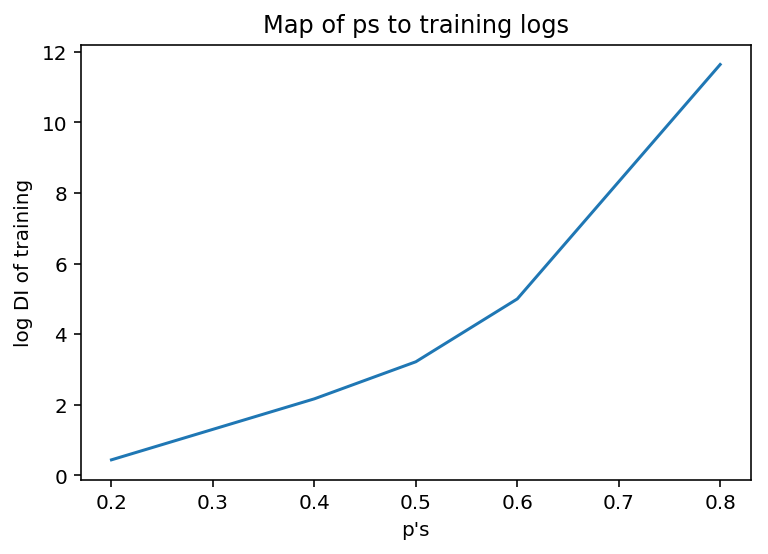

In [41]:
plt.plot(p_vals, logs_training)
plt.title("Map of ps to training logs")
plt.xlabel("p's")
plt.ylabel("log DI of training")

Text(0,0.5,'log DI of test')

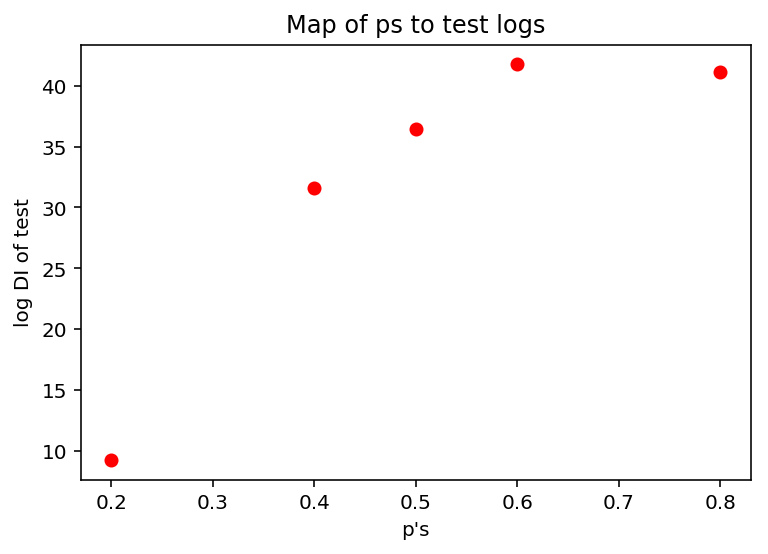

In [34]:
plt.plot(p_vals, logs_test, "ro")
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

Text(0,0.5,'log DI of test')

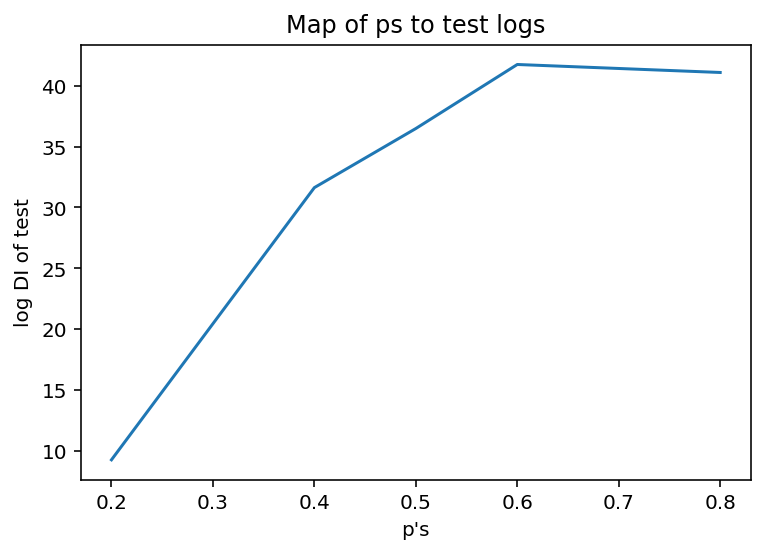

In [42]:
plt.plot(p_vals, logs_test)
plt.title("Map of ps to test logs")
plt.xlabel("p's")
plt.ylabel("log DI of test")

In [39]:
df_perturbed_training = pd.DataFrame(list_training)
df_perturbed_training = df_perturbed_training.T
df_perturbed_training.columns=p_vals
df_perturbed_training.to_csv("perturbed_training1.csv", index=False)
df_perturbed_test = pd.DataFrame(list_test)
df_perturbed_test = df_perturbed_test.T
df_perturbed_test.columns=p_vals
df_perturbed_training.to_csv("perturbed_test1.csv", index=False)

In [40]:
df_perturbed_training.head()

,0.2,0.4,0.5,0.6,0.8
0,"[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, ...","[0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, ...","[1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, ...","[0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, ...","[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, ..."
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, ...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, ...","[0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, ...","[0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
4,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, ...","[0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


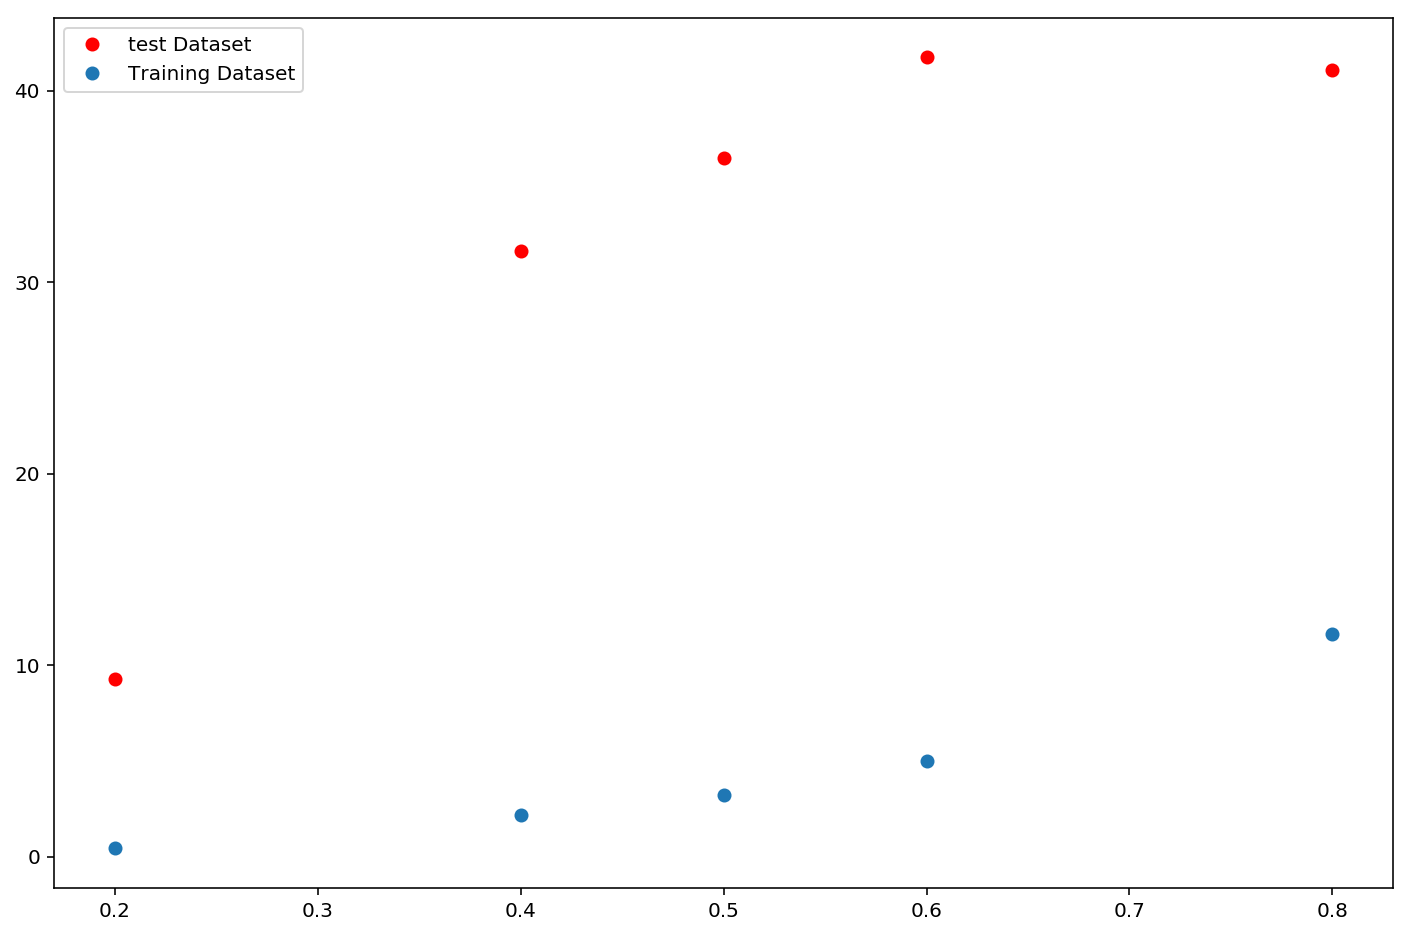

In [36]:
plt.figure(figsize=(12, 8))
plt.plot(p_vals, logs_test, "ro", label='test Dataset')
plt.plot(p_vals, logs_training, "o", label='Training Dataset')
plt.legend()